In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pywt

In [43]:
bicorn = pd.read_csv("./BCHAIN-MKPRU.csv")
gold = pd.read_csv("./LBMA-GOLD.csv")

In [82]:
bicorn.head()

,Date,Value,diff,DEA,MACD,EMA
0,9/11/16,621.65,0.000000,0.000000,0.000000,621.650000
1,9/12/16,609.67,-0.955670,-0.191134,-1.529071,617.656667
2,9/13/16,610.92,-1.593808,-0.471669,-2.244278,615.411111
3,9/14/16,608.82,-2.243132,-0.825961,-2.834341,613.214074
4,9/15/16,610.38,-2.601854,-1.181140,-2.841428,612.269383


In [45]:
gold.head()

,Date,USD (PM)
0,9/12/16,1324.60
1,9/13/16,1323.65
2,9/14/16,1321.75
3,9/15/16,1310.80
4,9/16/16,1308.35


### EMA & MACD 计算

In [46]:
def getMACD(data, short_period, long_period, period):
    '''
    data是包含高开低收成交量的标准dataframe
    short_period, long_period, period 分别是MACD的三个参数(快速（短期）和慢速（长期),移动平均)
    {  
        短线是6、15、6;中线是12、26、9;长线是30、60、30;
    }
    返回值是包含原始数据和 diff, DEA, MACD三个列的dataframe
    '''  
    
    data['diff']= data['Value'].ewm(adjust=False,alpha=2/(short_period+1),ignore_na=True).mean()-\
                  data['Value'].ewm(adjust=False,alpha=2/(long_period+1),ignore_na=True).mean()
    data['DEA'] = data['diff'].ewm(adjust=False,alpha=2/(period+1),ignore_na=True).mean()
    data['MACD']= 2*(data['diff']-data['DEA'])
    return data
getMACD(bicorn, 12, 26, 9)

,Date,Value,diff,DEA,MACD
0,9/11/16,621.65,0.000000,0.000000,0.000000
1,9/12/16,609.67,-0.955670,-0.191134,-1.529071
2,9/13/16,610.92,-1.593808,-0.471669,-2.244278
3,9/14/16,608.82,-2.243132,-0.825961,-2.834341
4,9/15/16,610.38,-2.601854,-1.181140,-2.841428
...,...,...,...,...,...
1821,9/6/21,51769.06,1755.210453,1803.524835,-96.628764
1822,9/7/21,52677.40,1906.923538,1824.204576,165.437925
1823,9/8/21,46809.17,1535.934833,1766.550627,-461.231589
1824,9/9/21,46078.38,1169.473997,1647.135301,-955.322609


In [47]:
def cal_macd_system(data, period):
#   period是时间跨度
    data['EMA'] = data['Value'].ewm(adjust=False,alpha=2/(period+1),ignore_na=True).mean()
    return data
cal_macd_system(bicorn, 5)

,Date,Value,diff,DEA,MACD,EMA
0,9/11/16,621.65,0.000000,0.000000,0.000000,621.650000
1,9/12/16,609.67,-0.955670,-0.191134,-1.529071,617.656667
2,9/13/16,610.92,-1.593808,-0.471669,-2.244278,615.411111
3,9/14/16,608.82,-2.243132,-0.825961,-2.834341,613.214074
4,9/15/16,610.38,-2.601854,-1.181140,-2.841428,612.269383
...,...,...,...,...,...,...
1821,9/6/21,51769.06,1755.210453,1803.524835,-96.628764,50151.599308
1822,9/7/21,52677.40,1906.923538,1824.204576,165.437925,50993.532872
1823,9/8/21,46809.17,1535.934833,1766.550627,-461.231589,49598.745248
1824,9/9/21,46078.38,1169.473997,1647.135301,-955.322609,48425.290165


### 数据小波降噪

In [78]:
# 封装成函数
def denoise_dealing(data):
    def sgn(num):
        if (num > 0):
            return 1.0
        elif (num == 0):
            return 0.0
        else:
            return -1.0
        
    def wavelet_noising(new_df):
        data = new_df
        data = data.values.T.tolist()  # 将np.ndarray()转为列表
        w = pywt.Wavelet('sym8')
        # [ca3, cd3, cd2, cd1] = pywt.wavedec(data, w, level=3)  # 分解波
        [ca5, cd5, cd4, cd3, cd2, cd1] = pywt.wavedec(data, w, level=5)  # 分解波

        length1 = len(cd1)
        length0 = len(data)

        Cd1 = np.array(cd1)
        abs_cd1 = np.abs(Cd1)
        
        median_cd1 = np.median(abs_cd1)

        sigma = (1.0 / 0.6745) * median_cd1
        lamda = sigma * math.sqrt(2.0 * math.log(float(length0), math.e))
        usecoeffs = []
        usecoeffs.append(ca5)
        #软硬阈值折中的方法
        a = 0.5

        for k in range(length1):
            if (abs(cd1[k]) >= lamda):
                cd1[k] = sgn(cd1[k]) * (abs(cd1[k]) - a * lamda)
            else:
                cd1[k] = 0.0

        length2 = len(cd2)
        for k in range(length2):
            if (abs(cd2[k]) >= lamda):
                cd2[k] = sgn(cd2[k]) * (abs(cd2[k]) - a * lamda)
            else:
                cd2[k] = 0.0

        length3 = len(cd3)
        for k in range(length3):
            if (abs(cd3[k]) >= lamda):
                cd3[k] = sgn(cd3[k]) * (abs(cd3[k]) - a * lamda)
            else:
                cd3[k] = 0.0

        length4 = len(cd4)
        for k in range(length4):
            if (abs(cd4[k]) >= lamda):
                cd4[k] = sgn(cd4[k]) * (abs(cd4[k]) - a * lamda)
            else:
                cd4[k] = 0.0

        length5 = len(cd5)
        for k in range(length5):
            if (abs(cd5[k]) >= lamda):
                cd5[k] = sgn(cd5[k]) * (abs(cd5[k]) - a * lamda)
            else:
                cd5[k] = 0.0

        usecoeffs.append(cd5)

        usecoeffs.append(cd4)
        usecoeffs.append(cd3)
        usecoeffs.append(cd2)
        usecoeffs.append(cd1)
        recoeffs = pywt.waverec(usecoeffs, w)
        return recoeffs

    data_denoising = wavelet_noising(data)  #调用小波去噪函数
    
    new_data_res = []    
    # 还原操作
    for i in range(len(new_data)-1):
        new_data_res.append((new_data[i]+new_data[i+1])/2)
    plt.plot(range(len((new_data_res))), new_data_res,'r')
    return new_data_res

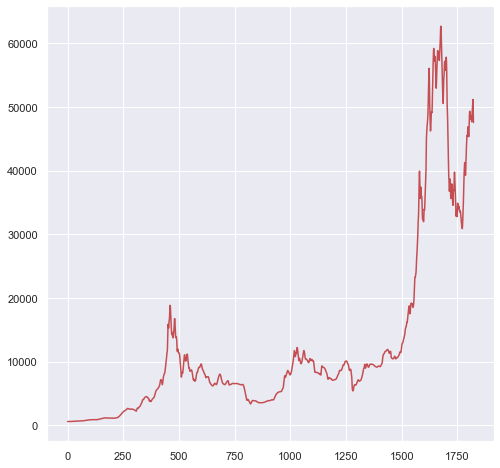

In [79]:
new_data = denoise_dealing(bicorn['Value'])

#### TEST

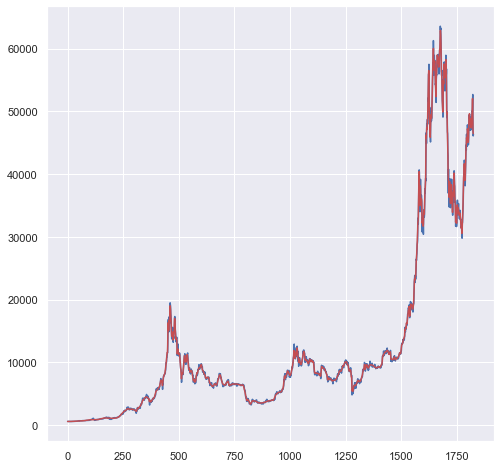

In [75]:
import seaborn
seaborn.set()
bit_value = bicorn['Value']
length_1 = len(bit_value)
length_2 = len(new_data_res)
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(range(length_1),bit_value,'b')
plt.plot(range(length_2),new_data_res,'r')
plt.tight_layout
plt.show()